\begin{titlepage}

% Photo of FS
\centering
\vspace{-40pt}
\includegraphics[width=0.8\textwidth]{Frankfurt_School_Logo.jpg}\par
\vspace{2.5cm}

% Course
{\scshape\huge Assignment 1 \par}
\vspace{2.5cm}

% Title
{\Huge\bfseries Covic-19 \& PCA Disasters \par}
{\scshape\large Studying the SIRD Model and Surrogate Data \par}

\vspace{2cm} % If signature is taken might have to add space.


{\Large Yannik Suhre \par}
{\Large Skyler MacGowan \par}
{\Large Debasmita Dutta \par}
{\Large Sebastian Sydow \par}
\vspace{0.5cm}

% Date
\vfill
{\large \today\par}
\end{titlepage}


\newpage

\hypersetup{linkcolor=black}
\tableofcontents

\newpage

# Introduction
\label{section:Introduction}

The following document provides our solutions for the given exercises. 

# Question 1

This code is based on prior work conducted by Jan Nagler; the modications made were effectuated in order to solve the following exercise problems:

* **a**. Derive the corresponding system of equations for S, I, R and D. E.g., $\frac{dD}{dt} = \mu I$ but this is not the only difference to SIR. In addition, the basic
reproduction number may now depend on µ as well, how? 

* **b**. Assume that the basic reproduction number $R_0$ for B.1.1.7 is not exactly known but only the range $R_0 \in [3.0; 4.0]$. Assume that the mortality rate µ is also not exactly known but only the range $\mu \in [0.4\%; 4\%]$. Study how these parameter uncertainties affect the prediction of D at t = 365d.

* **c**. Study numerically the effects of a hard versus soft lockdown (by two for you reasonable values of β), in terms of D(365d). Assume µ = 1% and a γ compatible with $R_0$ = 4. 

We will start by importing some packages that can be leveraged when solving the exercise problems.

In [1]:
#### Imports ####
import numpy as np
import pandas as pd
import math
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, PercentFormatter
from matplotlib import cm
from IPython.display import display, Markdown
from mpl_toolkits.mplot3d import Axes3D

# set matplotlib fontsize
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# set matplotlib to inline
%matplotlib inline

## Class Explanation
\label{section:Class_explanation}

In order to incorporate all the different things, and to do this with as less code as possible, we will define a class. Which methods this class contains and how the different methods work, will be displayed here.

<div class="alert alert-block alert-info">
<b>Note:</b> Bear in mind, that the following section will outline the docstrings for the different methods. Thus, these docstrings will <b>not</b> be displayed in the code when creating the class itself.
</div>

### Class creation
\label{section:class_creation}

The overall class is called ```SIRD``` in order to make explicit what this function is used for. It is defined like
```python
class SIRD():
   """This class alters the SIR model from Epidemiology in order
   to incorporate the deaths caused by the desease"""
```

Classes contain different methods and attributes. A method is defined within the class context as a normal function, using the ```def ...``` notation. Be aware, that since that method is defined **within** the class, it is only accessable through the class, meaning we have to use the class object in order to execute it.

In order to give a class its attributes we can make use of the ```self```. Using this name we can create and update parameters which belong to the class (*how this is done exactly will be shown later*). In order to have a clear overview, of how to create a class and which parameters to give it, let us explain the double underscore (*dunder*) function ```__init__()```. This is the function, which will be called, when the object is instantiaded (*E.g. ```SIRD()```; the ```()``` means instantiaded in this context*).

```Python
def __init__(self, N: int, I0: float, R0: float, D0: float, beta: float,
                 gamma: float, mu: float, recovery_in_days: int,  days: int):
    """This functions adds the given parameters to the object, which
    is instantiated using the SIRD class.
    
    Within this class, we also calculate R_nought, the basic reproduction
    number R_0 (pronounced R-nought) which is the average number of cases
    directly generated by one case in a population where all individuals
    are susceptible to infection using the formula
    R_nought = beta / (gamma + mu) and we calculate S0, which displays
    the number of susceptible persons, using the formula 
    S0 = S0 = N - I0 - R0 - D0.

    Parameters
    ----------
    N : int
        Represents the populations size, if you set it to 1,
        the model will ignore N and it will return fractions
    I0 : float
        The total number of infected people at time zero
    R0 : float
        The total number of recovered people at time zero
    D0 : float
        The total number of death at the time zero
    beta : float
        The contact rate, more specifically how many people
        does one infected infects
    gamma : float
        The recovery rate, the rate of how fast infected people
        recover from the desease
    mu : float
        The mortality rate, the rate of how many of the infected
        people die
    recovery_in_days : int
        The days it takes to recover, this could also be
        calculated using 1/gamma, but was inserted here 
        for easier accessability
    days : int
        The timeframe, how long we will model the infectious disaster
    """
```

### Derivate function
\label{section:deriv}


Next we can set up the $SIR(D)$ model. For the most part this is the function developed by Jan Nagler, albeit with some modifications that allow us to incorperate the mortility rate $\mu$.

```python
def _deriv(self, y, t, N, beta, gamma, mu):
    """Altered function of the SIR model,
    in order to incorporate the deaths,
    mu.

    Parameters
    ----------
    y : ndarray
        This array contains the initial models
    t : np.array
        A np.array created using np.linespace in
        order to model the time
    N : int
        The population size or 1
    beta : float
        The contact rate, more specifically how many people
        does one infected infects
    gamma : float
        The recovery rate, the rate of how fast infected people
        recover from the desease
    mu : float
        The mortality rate, the rate of how many of the infected
        people die
    """
```

### Effective reproduction number
\label{section:brn}


Yet another very important number when it comes to epidemiology is the **effective reproduction number**, which will be denoted by $R_{effective}$. The idea behind this number is that at any given time $t$ an unknown number of the susceptible population is immune to the disease, *or the average number of new infections caused by a single infected individual at time t in the partially susceptible population* [[3](https://en.wikipedia.org/wiki/Basic_reproduction_number#Effective_reproduction_number), [4](https://www.healthknowledge.org.uk/public-health-textbook/research-methods/1a-epidemiology/epidemic-theory)]. As soon as this number drops below one, one can speak of *herd immunity*. Thus $R_e$ can be defined by $R_0 * \frac{susceptibles}{population}$.

For our model, we can calculate this using the following method.

```python
def _R_effective(self, subplot = False):
    """Calculates the effective reproduction number
    based on the formulae given by Jan Nagler.

    Parameters
    ----------
    subplot : bool, optional
        If true, it will return
        the time when the BRN reaches
        its maximum, by default False
    """
```

### Ordinary differential equation
\label{section:ode}


Now, we will make use of the ```odeint()``` function, which *integrates a system of ordinary differential equations* [[2](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html)]. The first argument for this function must be therefore a callable object, such as a function (e.g. *a callable object is everything which can be called using ```()```*). Its second argument is the vector with the initial conditions. Third, we have to specify the time variable; this was also done above ($t$) in the ```__init__()``` functon. In order to pass the function arguments to our given callable, we also need to specify the argument `args` with all the inputs the callable needs.

```python
def _ode(self):
    """Integrates different ordinary differential
    equations."""
```

### Calculate $\beta$ and $\gamma$
\label{section:beta_gamma}


In question 1.b the solution requieres us, to vary $R_{nought}$ and $\mu$. Since those two parameters are depended on $\gamma$ and $\beta$, we also have to recalculate those. Hence our class has a function for it.

```python
def _get_beta_gamma(self, R_nought, mu):
    """Returns beta and gamma based
    on recovery time and infectious power R
    
    Parameters
    ----------
    R_nought : float
        The basic reproduction number R_0
        (pronounced R-nought) which is the
        average number of cases directly
        generated by one case in a population
        where all individuals are susceptible
        to infection
    mu : float
        The mortality rate, the rate of how many of the infected
        people die
    """
```

### Plot $\mu$ and $R_{nought}$ w.r.t. cumulated deaths
\label{section:plot_mu_brn_wrt_cd}


Until now, we have just dealed with methods/functions which started with an underscore. Those are named *private* functions. These functions should **not** be used by anyone outside of the developer team. The usage for developing such *private* functions is, that those can then be used in the *public* functions of this class.

From here onwards, we will present our *public* functions. The first one is a function, which allows us to plot $\mu$ and $R_{nought}$ w.r.t. the cumulated deaths.

```python
def plot_mu_bn_wrt_cd(self, R_nought, mu, subplot = True):
    """This function makes use of the private functions,
    in order to calculate the fraction of deaths for
    question 1.b.
    
    Parameters
    ----------
    R_nought : float
        The basic reproduction number R_0
        (pronounced R-nought) which is the
        average number of cases directly
        generated by one case in a population
        where all individuals are susceptible
        to infection
    mu : float
        The mortality rate, the rate of how many of the infected
        people die
    subplot : bool, optional
        If true, it will return
        the time when the BRN reaches
        its maximum, by default False
    """
```

### Plot
\label{section:plot}


Lastly, in order to plot all of our things, we need to define a plotting function. This is done in the next step.

```python
def plot(self, subplot = False):
    """This functions uses as well
    all of the above defined private
    functions and then goes ahead and
    plots a graph, which visualizes
    the different functions.
    
    Parameters
    ----------
    subplot : bool, optional
        If true, it will return
        the time when the BRN reaches
        its maximum, by default False
```

## Class definition
\label{section:Class_def}

As shown above, a number of variables and functions are needed to solve the exercises problems. In the next cell, we will define a class that incorporates said variables/functions. The advantage of using a class is that we can easily change a given parameter and readily see/understand how doing so impacts the other parameters at play.

<div class="alert alert-block alert-info">
<b>Note:</b> Should any questions arise regarding the methods usage, please scroll up and review the respective docstrings.
</div>

In [2]:
class SIRD:

    def __init__(self, N: int, I0: float, R0: float, D0: float, beta: float,
                 gamma: float, mu: float, recovery_in_days: int,  days: int):
        self.N = N
        self.S0 = N - I0 - R0 - D0
        self.I0 = I0
        self.R0 = R0
        self.D0 = D0
        self.beta = beta
        self.gamma = gamma
        self.mu = mu
        self.R_nought = beta / (gamma + mu)
        self.recovery_in_days = recovery_in_days
        self.t = np.linspace(0, days, days)
    
    def _deriv(self, y, t, N, beta, gamma, mu):
        S, I, R, D = y
        # dSdt = - contact rate * the susceptibles * infected / total population
        # How many of the population is susceptible to the virus?
        dSdt = -beta * S * I / N
        # dIdt = contact rate * susceptibles * infected / total population - recovery rate * infected - 
        # mortality rate * infected
        # How many of the susceptibles will contract the virus?
        dIdt = beta * S * I / N - gamma * I - mu * I
        # dRdt = recovery rate * infected
        # How many of those that are infected recover excluded those that die?
        dRdt = gamma * I
        # dDdt = mortility rate * infected
        # How many of those that are infected will die?
        dDdt = mu * I
        return dSdt, dIdt, dRdt, dDdt
    
    def _R_effective(self, subplot = False):
        self.t_1 = 0
        for time in range(0,len(self.S)):
            if self.R_nought*self.S[time]/self.N < 1: 
                self.t_1 = time
                break
        if not subplot:
            display(Markdown(rf"$R_e$ = 1 after {self.t_1} days!"))
    
    def _ode(self):
        y0 = self.S0, self.I0, self.R0, self.D0
        ret = odeint(self._deriv, y0, self.t, args=(self.N, self.beta, self.gamma, self.mu))
        self.S, self.I, self.R, self.D = ret.T
        
    def _get_beta_gamma(self, R_nought, mu):
        self.gamma = 1./self.recovery_in_days
        self.beta = R_nought*(self.gamma + mu)
    
    def plot_mu_bn_wrt_cd(self, R_nought, mu, subplot = True):
        self._get_beta_gamma(R_nought, mu)
        self._ode()
        self._R_effective(subplot)
        self.fraction_deaths = self.D[-1]/self.N
        return self.fraction_deaths
        
    def plot(self, subplot = False):
        self._ode()
        self._R_effective(subplot)
        fig = plt.figure(facecolor='w', figsize = (16,8))
        ax = fig.add_subplot(111, axisbelow=True)
        ax.plot(self.t, self.S/self.N, alpha=0.5, lw=2, label='$S_{usceptible}$')
        ax.plot(self.t, self.I/self.N, alpha=0.5, lw=2, label='$I_{nfected}$')
        ax.plot(self.t, self.R/self.N, alpha=0.5, lw=2, label='$R_{ecovered}$')
        ax.plot(self.t, self.D/self.N, alpha=0.5, lw=2, label='$D_{eath}$')
        ax.plot(self.t, self.R_nought*self.S/self.N, alpha=0.5, lw=2, label='$R_{effective}$')
        ax.plot(self.t, np.full(len(self.t), self.R_nought), alpha=0.5, lw=2, label='$R_{nought}$')
        ax.set_xlabel('Time / days')
        ax.set_ylabel('Fraction')
        ax.set_ylim(0,2.2)
        ax.vlines(self.t_1, 0, 1, colors='k', linestyles='dashed')
        ax.yaxis.set_tick_params(length=0)
        ax.xaxis.set_tick_params(length=0)
        ax.grid(b=True, which='major', c='w', lw=2, ls='-')
        legend = ax.legend(fontsize="large", loc = "upper right")
        legend.get_frame().set_alpha(0.5)
        
        plt.text(0.2, 0.75, f"The BRN is: {round(self.R_nought,2)}",
                     transform=ax.transAxes)
        plt.text(0.2, 0.4, f"D = t(365): {round(sum(self.D),2)}",
                     transform=ax.transAxes)
        
        for spine in ('top', 'right', 'bottom', 'left'):
            ax.spines[spine].set_visible(False)
        if subplot:
            x = list(map(lambda x: plt.gca().lines[x].get_xdata(), range(5)))
            y = list(map(lambda x: plt.gca().lines[x].get_ydata(), range(5)))
            lines, labels = ax.get_legend_handles_labels()
            plt.close()
            return x, y, lines, labels
        else:
            plt.show()

Now lets use this class, in order to instantiated it.

In [3]:
model = SIRD(N = 1, I0 = 0.2, R0 = 0, D0 = 0,
            beta = 0.39, gamma = 0.15, mu = 0.01,
            recovery_in_days = 14, days= 365)

## Answers
### a)

The model exibited by the above graphs uses a $\gamma$ (meaning the recovery rate) of 0.15. This is an important part of the equation used to determine the Basic Reproduction Number (BRN), also referred to as "R Nought". Essentially, the BRN indicates how many individuals an infected person is likely to pass the virus onto during the course of his/her infection. As the recovery rate consitutes part of the denominator in this equation, increasing the recovery rate will decrease the virus's BNR. The second component of the denominator to calculate the BRN is the virus's mortality rate, represented by mu. Why should this variable be accounted for when calculating the BRN? Well that's because when someone dies he/she will no longer pass on the infection, i.e. in terms of their "infectious potential" they are treated the same as someone who had the virus and then recovered. Accordingly, just as with the recovery rate, increases to the mortality rate will decrease the BRN. <br>

<u>Note</u>: Treating a cadaver as having no infectious potential may be erroneous, but considering how one might incorporate this the infectious potential of deceased individuals is beyond the scope of this assignment. Our model is also limited by the fact that the mortality rate does not account for natural deaths, assuming simply that all deaths were a result of the virus. 

---

### b) <br>
<b>TO DO</b>: Incorporate/use Sebastian's plot. 

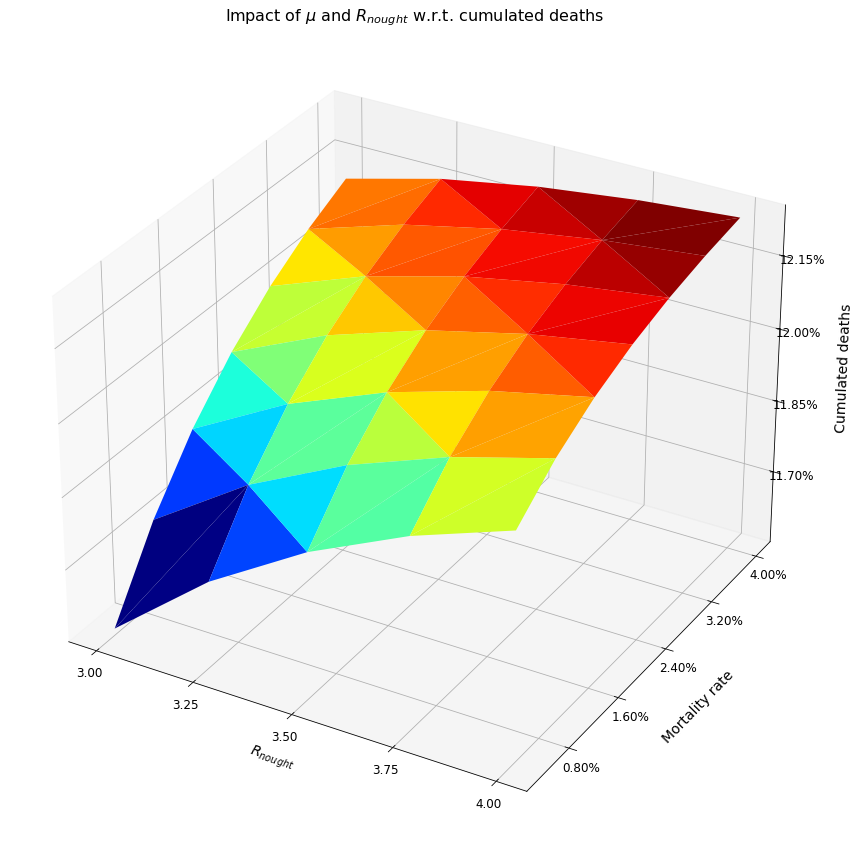

In [4]:
# range of r_nought:
r_nought = list(map(lambda x: x/100, range(300, 401, 25)))
    
# range of mortality rate:
mu = list(map(lambda x: x/1000, range(4, 41, 6)))

# create empty lists
r_nought_plot, mortalility_rate_plot, cum_deaths_plot = [], [], []

for i in r_nought:
    for j in mu:
        fraction_dead = model.plot_mu_bn_wrt_cd(i, j)
        
        r_nought_plot.append(i)
        mortalility_rate_plot.append(j)
        cum_deaths_plot.append(fraction_dead)

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_trisurf(r_nought_plot,
                       mortalility_rate_plot,
                       cum_deaths_plot,
                       linewidth=0.5, cmap=cm.jet, antialiased=True)
ax.set_title("Impact of $\mu$ and $R_{nought}$ w.r.t. cumulated deaths")
ax.set_xlabel('$R_{nought}$', labelpad = 10)
ax.set_ylabel('Mortality rate', labelpad = 20)
ax.set_zlabel('Cumulated deaths', labelpad = 20)
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
ax.zaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(5))
ax.zaxis.set_major_locator(MaxNLocator(5))
plt.show()

---
### c)

The graphs above illustrate how increases in either the virus's BRN or its mortality rate will result in a greater cumulative number of deaths that occur over a one-year period. Of these two variables, increases in the mortality rate will have a more profound impact on the ensuing deaths.  <br>

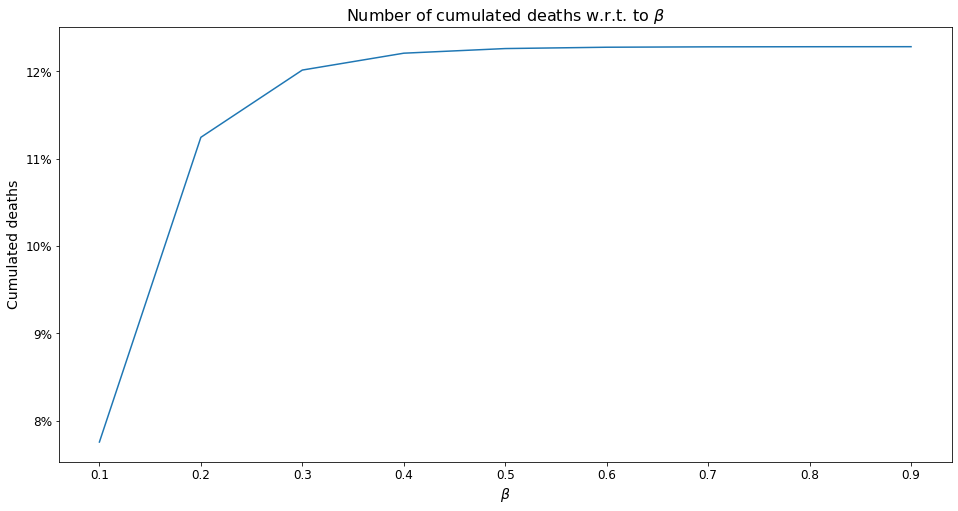

In [5]:
model.mu = 0.01
model.R_nought = 4
model.gamma = 0.04
betas = list(map(lambda x: x/10, range(1, 10, 1)))[::-1]
cum_deaths, beta = [], []
for infection_rate in betas:
    model.beta = infection_rate
    model.R_nought = model.beta / (model.gamma + model.mu)
    fraction_dead = model.plot_mu_bn_wrt_cd(model.R_nought, model.mu)
    cum_deaths.append(fraction_dead)
    beta.append(infection_rate)
    
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1,1,1)
plt.plot(beta, cum_deaths)
plt.title(r"Number of cumulated deaths w.r.t. to $\beta$")
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0, symbol='%', is_latex=False))
plt.xlabel(r"$\beta$")
plt.ylabel("Cumulated deaths")
plt.show("Cumulated deaths")

For a hard lockdown the beta should be lower, and vice versa. <br>
<b><u>April 13 Meeting</u>: We are forgoing this question for the time being, and will return to it on April the 15th.</b>

### b), c)
Yes, you can derive and plot the effective reproduction number, R, as a function of time, given otherwise fixed parameters. Indeed doing just that is the purpose of the $R_{effective}$() function defined above.

In the hereafter cell, one can see how to access a function/method through a class object. Earlier we instantiaded model to be an object of class ```SIRD```, now we can use the dot notation (```.plot()```) to access the ```plot``` function.

$R_e$ = 1 after 0 days!

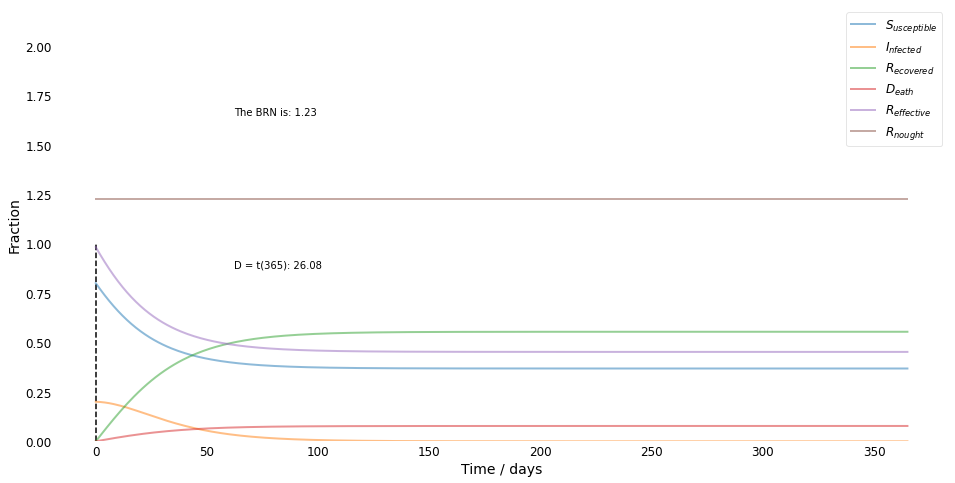

In [ ]:
model.plot()

# Question 2

Create labeled surrogate data sets. Perform a PCA/Class prediction with ovr logistic regression analysis as developed in the lecture.

* **a:** 4 blobs: Create clearly separable 4-blobs in 3d but also a ’disaster’ realization with strong overlaps. Study, show and compare elbow plots and prediction boundaries.

* **b:** 2 touching parabola spreads as shown in the lecture, but in 3d (not 2d). Study and show elbow plot and prediction boundaries.

In [ ]:
### imports ###
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

## Class Explanation
Like in exercise one, we will start this exercise by explaining our class, we used in order to solve it. This gives us the benefit that we can easily alter specific measures and *study* the impact thereof.

<div class="alert alert-block alert-info">
<b>Note:</b> Bear in mind, that the following section will outline the docstrings for the different methods. Thus, these docstrings will <b>not</b> be displayed in the code when creating the class itself.
</div>

### Class creation
The here used class is called ```Blobs_and_parabolas```, since this exactly what this is created for. To easily create surrogate data. This is how it is defined:

```python
class Blobs_and_parabolas():
    """A class to create, plot and analyize surrogate
    data with different parameters."""
```

Classes contain different methods and attributes. A method is defined within the class context as a normal function, using the ```def ...``` notation. Be aware, that since that method is defined **within** the class, it is only accessable through the class, meaning we have to use the class object in order to execute it.

```python
def __init__(self, n_samples = 250, n_features = 13, centers = 4,
             cluster_std = 1, center_box =(-50,50), blob = None, parabola = None):
    """This function instantiates the class Blobs and parabolas,
    with the shortly defined parameters. Its benefit is, that 
    we can easily alter some parameters to change data. This
    class also already goes ahead and creates new class attributes
    like it is already creating the train-test-split and whatnot.

    Parameters
    ----------
    n_samples : int, optional
        How many samples do you want per blob, by default 250
    n_features : int, optional
        How many features do you want your blob or respective 
        parabola to have, by default 13
    centers : int, optional
        How many centers should your blobs have, by default 4
    cluster_std : int, optional
        How large should be the standard deviation,
        if you increase this number as can be seen later,
        you can more unclear surrogate data, by default 1
    center_box : tuple, optional
        In which boundry should the surrogate data
        be created, by default (-50,50)
    blob : [type], optional
        Do you want to create surrogate data for
        a blob set this to True, by default None
    parabola : [type], optional
        Do you want to create surrogate data for
        a parabola set this to True, by default None
    """
```

### PCA and logistic regression
The goal of this exercise is, to make a *one-versus-rest* linear regression in combination of PCA. In order to do that, we have created a function called ```_pca_and_lr```.

```python
def _pca_and_lr(self, n_components = 2):
    """This function takes the data which is available
    within its object and transforms a PCA and a logistic
    regression with the one-versus-rest logic.

    Parameters
    ----------
    n_components : int, optional
        Number of dimensions the data
        should be reduced to by PCA, by default 2
    """
```

### Plot the decision regions
In order to see how good or bad the data could still be separated after we used PCA and logistic regression, we created a function, which can still plot the decision boundry. As you might have noticed is the function ```_pca_and_lr``` also a *private* function, since it starts with a underscore. The PCA function is first then called, when we use the ```plot_decision_regions``` function.

```python
def plot_decision_regions(self, resolution=0.01):
    """Reduces the data using the _pca_and_lr function and then plots
    the decision regions plot to showcase of how good the data could
    be separated after we reduced its in its dimensions.

    Parameters
    ----------
    resolution : float, optional
        Parameter for the np.meshgrid function, by default 0.01
    """
```

## Class definition

In the next step we implemented the above descripted class.

<div class="alert alert-block alert-info">
<b>Note:</b> Should any questions arise regarding the methods usage, please scroll up and review the respective docstrings.
</div>

In [ ]:
class Blobs_and_parabolas():
    
    def __init__(self, n_samples = 250, n_features = 13, centers = 4, cluster_std = 1, center_box =(-50,50),
                blob = None, parabola = None):
        if blob:
            self.X, self.y = make_blobs(n_samples = n_samples,
                                        n_features = n_features,
                                        centers = centers,
                                        cluster_std = cluster_std,
                                        center_box = center_box)
        elif parabola:
            self.X, self.y = make_moons(n_samples = 10000)
            self.X = np.column_stack((self.X, np.random.choice(self.X[:,1], (len(self.X),n_features))))
            self.idx = self.y == 1
        else:
            assert("Please select either blob = True or parabola = True")
            
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
                                self.X, self.y, test_size=0.3, stratify=self.y, random_state=0)
        # Standardize the features (zero mean, unit variance) 
        self.sc = StandardScaler()
        # Fit results must be used later (mu and sigma)
        self.X_train_std = self.sc.fit_transform(self.X_train)
        # Normalize test data set with mu/sigma of training data
        self.X_test_std = self.sc.transform(self.X_test)
        self.cov_mat = np.cov(self.X_train_std.T) #cov matrix from data
        self.EVal, self.EVec = np.linalg.eig(self.cov_mat)
        self.sum_EVal = sum(self.EVal)
        self.var_exp = [(i / self.sum_EVal) for i in sorted(self.EVal, reverse=True)]
        
    def _pca_and_lr(self, n_components = 2):
        # Set up PCA and logistic regression model
        self.pca = PCA(n_components= n_components)
        self.lr = LogisticRegression(multi_class='ovr', solver='liblinear')

        # Fit and transform training data, given on PCA reduction to k(=2) principle components
        self.X_train_pca = self.pca.fit_transform(self.X_train_std)
        self.X_test_pca = self.pca.transform(self.X_test_std)
        # solves task, given 3 classes (as from y_train) 
        self.lr.fit(self.X_train_pca, self.y_train)
        
    def plot_decision_regions(self, resolution=0.01):
        self._pca_and_lr()
        # Does not work....always....Setup marker generator and color map: FIXED!
        colors = ('r', 'b', 'g', "y")
        markers = ('s', 'v', 'o', 'p') 
        cmap = ListedColormap(colors[:len(np.unique(self.y_train))])

        # plot the decision surface
        x1_min, x1_max = self.X_train_pca[:, 0].min() - 1, self.X_train_pca[:, 0].max() + 1
        x2_min, x2_max = self.X_train_pca[:, 1].min() - 1, self.X_train_pca[:, 1].max() + 1
        xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                               np.arange(x2_min, x2_max, resolution))

        # Z is the prediction of the class, given point in plane
        Z = self.lr.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
        Z = Z.reshape(xx1.shape)

        # Z=f(xx1,yy1), plot classes in plane using color map but opaque
        plt.contourf(xx1, xx2, Z, alpha=0.2, cmap=cmap)
        plt.xlim(xx1.min(), xx1.max())
        plt.ylim(xx2.min(), xx2.max())

        # Plot data points, given labels
        for idx, cl in enumerate(np.unique(self.y_train)):
            plt.scatter(x=self.X_train_pca[self.y_train == cl, 0], 
                        y=self.X_train_pca[self.y_train == cl, 1],
                        alpha=0.6, 
                        c=[cmap(idx)],
                        edgecolor='black',
                        marker=markers[idx], 
                        label=cl)

<div class="alert alert-block alert-info">
<b>Note:</b> In order to present the different changes, if we go from clearly separable to unclear and unseparable, we will use the prefix <i>cs_</i> for clearly separable and <i>uc_</i> for unclear separable.
</div>

Here we use our defined class, in order to create surrogate blob data. Once (```cs```) with a small standard deviation and the aforementioned default parameters, and once with a higher standard deviation around each cluster (```uc```).

In [ ]:
cs = Blobs_and_parabolas(blob = True)
uc = Blobs_and_parabolas(blob = True, cluster_std = 30)

In [ ]:
fig = plt.figure(figsize = (12,12))
  
# syntax for 3-D projection
ax = plt.axes(projection ='3d')
ax.scatter3D(cs.X[:, 0], cs.X[:, 1], cs.X[:, 2], label = "Clearly Separable")
ax.scatter3D(uc.X[:, 0], uc.X[:, 1], uc.X[:, 2], label= "Not clear separable")
ax.legend()
plt.title("Clearl and unclear separable blobs")
plt.show()

In [ ]:
# Plot explained variances
fig, ax = plt.subplots(1,2, figsize = (16,8))
ax[0].bar(range(1,14), cs.var_exp, 
        align='center', label='individual, explained variance', color = "C0")
ax[0].set_ylabel('Explained variance ratio')
ax[0].set_xlabel('Principal component index')
ax[0].set_title("Clearly separable blobs")
ax[0].set_ylim(0,0.6)
ax[1].bar(range(1,14), uc.var_exp, 
        align='center', label='individual, explained variance', color = "C1")
ax[1].set_xlabel('Principal component index')
ax[1].set_ylim(0,0.6)
ax[1].set_ylabel('Explained variance ratio')
ax[1].set_title("Unclear separable blobs")
plt.show()

In [ ]:
plt.figure(figsize = (16, 8))

plt.subplot(121)
cs.plot_decision_regions()
plt.title("Clearly separable by PCA")

plt.subplot(122)
uc.plot_decision_regions()
plt.title("Not so clearly separable by PCA")
plt.show()

## Answers

### a)

Under the current parameters, there is a clear separation between classes zero and one, but classes two and three represent a disaster realization and hence overlap significantly. 

<b>To Do</b>
- Subject to your guys' thoughts I'd say let's create a bunch of different plots showing how the class separation looks when we using different decision boundaries, and then just provide a few sentences summarizing what these plots show. 
- Also I think he wants at least one of the plots to contain classes that are all clearly separable.
- I think he also wants us to show the corresponding elbow histograms for each blob plot made. 

<b>Questions for Group</b> <br>
1) Are you guys clear on what Nagler means by a "disaster realization"? <br>
2) He asks us to show the elbow plots as well as the prediction boundary. Does he mean a decision boundary rather than a prediction boundary? I'm not really sure what a prediction boundary would be. 

### b)
In the parabola spread visualizations shown above, one can see how the data on the sides of each parabola is easily identified as being part of one class or the other. That is not the case for the data points near each vertex, as the vertices get quite close to each another and actually touch at one point. <br>
<b>So what? What is the takeway?</b>



<b>Questions</b><br>
1) So to confirm, the parabola spreads are another way of classifying the blobs right?
2) Perhaps the approach we take here is similar to what we do in 2a, just here the visualization are the 3d parabolic spreads?

Here are creating different surrogate data for the parabolas. The ```cs``` variable contains only 3D data for the first parabola. The second variable ```uc``` contains the 3D data and is furthermore enriched by other features, in order to show the differences in the elbow plot later. 

In [ ]:
cs = Blobs_and_parabolas(parabola = True, n_features = 1)
uc = Blobs_and_parabolas(parabola = True)

In [ ]:
fig = plt.figure(figsize = (12,12))
  
# syntax for 3-D projection
ax = plt.axes(projection ='3d')
ax.scatter3D(cs.X[cs.idx, 0]-1, cs.X[cs.idx, 1], cs.X[cs.idx, 2])
ax.scatter3D(cs.X[~cs.idx, 0], cs.X[~cs.idx, 1]-1.5, cs.X[~cs.idx, 2], color = "C0")
plt.title("Low dimensional data parabolas")
plt.show()

In [ ]:
# Plot explained variances
fig, ax = plt.subplots(1,2, figsize = (16,8), sharey = True)
ax[0].bar(range(0,3), cs.var_exp, 
        align='center', label='individual, explained variance')
ax[0].set_ylabel('Explained variance ratio')
ax[0].set_xlabel('Principal component index')
ax[0].set_title("Clearly separable blobs")
ax[1].bar(range(0,15), uc.var_exp, 
        align='center', label='individual, explained variance')
ax[1].set_xlabel('Principal component index')
ax[1].set_title("Unclear separable blobs")
plt.legend(loc='best')
plt.show()

In [ ]:
plt.figure(figsize = (16, 8))

plt.subplot(121)
cs.plot_decision_regions()
plt.title("Clearly separable by PCA")

plt.subplot(122)
uc.plot_decision_regions()
plt.title("Not so clearly separable by PCA")
plt.show()